# Overview
The notebook shows how the ```lime_image``` tools can be applied to a slightly larger dataset like the Olivetti Faces. The dataset is very low resolution and allows quite a bit of rapid-iteration.

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray # since the code wants color images
from skimage.util.montage import montage2d # to make a nice montage of the images

In [77]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()
# make each image color so lime_image works correctly
X_vec = np.stack([gray2rgb(iimg) for iimg in faces.data.reshape((-1, 64, 64))],0)
y_vec = faces.target.astype(np.uint8)

(-0.5, 1279.5, 1279.5, -0.5)

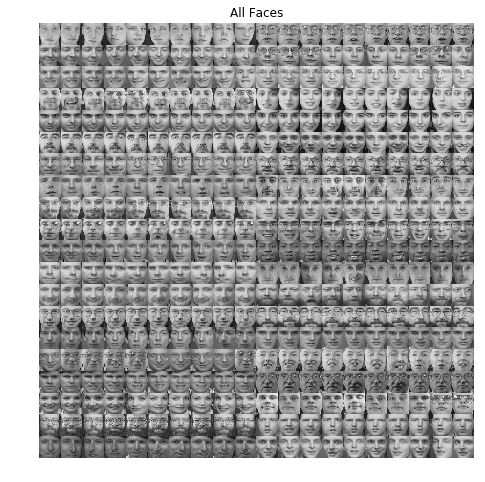

In [78]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.imshow(montage2d(X_vec[:,:,:,0]), cmap='gray', interpolation = 'none')
ax1.set_title('All Faces')
ax1.axis('off')

# Setup a Pipeline
Here we make a pipeline for processing the images where basically we flatten the image back to 1d vectors and then use a RandomForest Classifier

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)

makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('Normalize', Normalizer()),
    ('PCA', PCA(25)),
    ('XGBoost', GradientBoostingClassifier())
                              ])

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size=0.70)

/home/ubuntu/anaconda2/envs/test-lime35/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [81]:
simple_rf_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('Make Gray', <__main__.PipeStep object at 0x7f6bf24a6d30>), ('Flatten Image', <__main__.PipeStep object at 0x7f6bf24a6a58>), ('Normalize', Normalizer(copy=True, norm='l2')), ('PCA', PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

# Scoring the Model
We show the scoring of the model on the test data to see how well it works


In [82]:
# compute on remaining test data
pipe_pred_test = simple_rf_pipeline.predict(X_test)
pipe_pred_prop = simple_rf_pipeline.predict_proba(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, y_pred = pipe_pred_test))

             precision    recall  f1-score   support

          0       0.25      0.33      0.29         3
          1       0.50      0.75      0.60         4
          2       0.50      0.67      0.57         3
          3       0.00      0.00      0.00         1
          4       1.00      0.67      0.80         3
          5       0.57      1.00      0.73         4
          6       0.00      0.00      0.00         1
          7       0.33      0.50      0.40         2
          8       0.67      0.50      0.57         4
          9       0.67      0.40      0.50         5
         10       1.00      0.14      0.25         7
         11       0.25      0.50      0.33         2
         12       0.33      0.67      0.44         3
         13       1.00      1.00      1.00         2
         14       0.25      0.25      0.25         4
         15       0.00      0.00      0.00         2
         16       0.60      1.00      0.75         3
         17       0.50      0.75      0.60   

/home/ubuntu/anaconda2/envs/test-lime35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda2/envs/test-lime35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [84]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)

In [85]:
%%time
explanation = explainer.explain_instance(X_test[0], 
                                         classifier_fn = simple_rf_pipeline.predict_proba, 
                                         top_labels=6, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

CPU times: user 7.05 s, sys: 13.4 s, total: 20.4 s
Wall time: 6.74 s


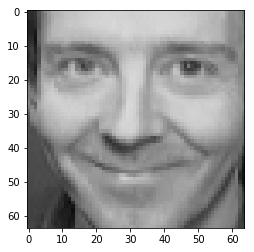

In [86]:
plt.imshow(X_test[0])

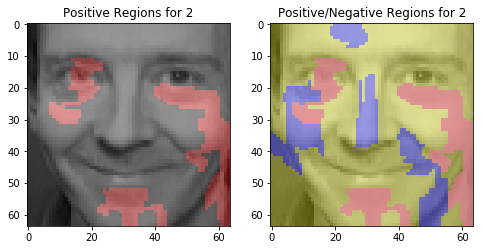

In [87]:
from skimage.color import label2rgb
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=True, num_features=5, hide_rest=False)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[0]))
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=False, num_features=10, hide_rest=False)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[0]))

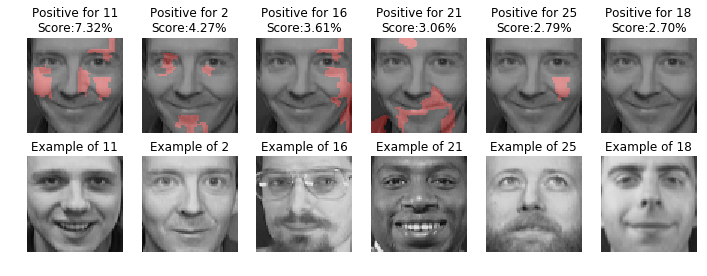

In [88]:
# now show them for each class
fig, m_axs = plt.subplots(2,6, figsize = (12,4))
for i, (c_ax, gt_ax) in zip(explanation.top_labels, m_axs.T):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=5, hide_rest=False, min_weight=0.01)
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(i, 100*pipe_pred_prop[0, i]))
    c_ax.axis('off')
    face_id = np.random.choice(np.where(y_train==i)[0])
    gt_ax.imshow(X_train[face_id])
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')

# Gaining Insight
Can we find an explanation for a classification the algorithm got wrong

In [89]:
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])

print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test[wrong_idx], pipe_pred_test[wrong_idx]))

Using #26 where the label was 20 and the pipeline predicted 11


In [90]:
%%time
explanation = explainer.explain_instance(X_test[wrong_idx], 
                                         classifier_fn = simple_rf_pipeline.predict_proba, 
                                         top_labels=6, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

CPU times: user 9.5 s, sys: 21.7 s, total: 31.2 s
Wall time: 7.35 s


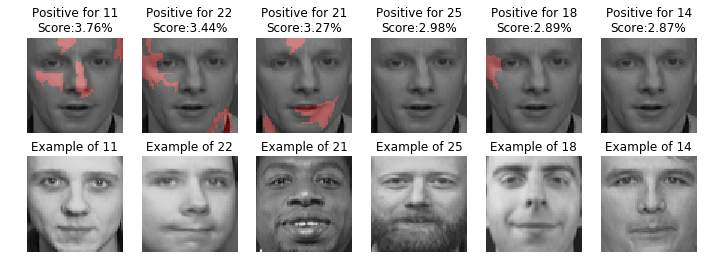

In [91]:
# now show them for each class
fig, m_axs = plt.subplots(2,6, figsize = (12,4))
for i, (c_ax, gt_ax) in zip(explanation.top_labels, m_axs.T):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=5, hide_rest=False, min_weight=0.01)
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(i, 100*pipe_pred_prop[wrong_idx, i]))
    c_ax.axis('off')
    face_id = np.random.choice(np.where(y_train==i)[0])
    gt_ax.imshow(X_train[face_id])
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')